In [1]:
# Instalación de librerías necesarias
!pip install qiskit qiskit-aer pylatexenc ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.6 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=b00e88960c7dcc1eb54c47fc8edaf5f0d058fe56a1abe1abdc9b0ee6abf5b14a
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram

# ==============================================================================
# 1. GESTOR DE RUIDO (Simulación de Eve / Hardware)
# ==============================================================================
def obtener_simulador(tipo_escenario, nivel_ruido=0.0):
    """
    Retorna un simulador configurado.
    tipo_escenario: 'Ideal' o 'Con Espía (Eve)/Ruido'
    nivel_ruido: float entre 0.0 y 1.0
    """
    if tipo_escenario == 'Ideal':
        return AerSimulator()
    else:
        # Modelo de ruido (Eve interceptando o decoherencia)
        noise_model = NoiseModel()
        # Error en 1 qubit (afecta compuertas X, H, Medición - BB84)
        error_1q = depolarizing_error(nivel_ruido, 1)
        # Error en 2 qubits (afecta CX - E91/Entrelazamiento)
        error_2q = depolarizing_error(nivel_ruido, 2)

        noise_model.add_all_qubit_quantum_error(error_1q, ['x', 'h', 'measure', 'ry'])
        noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

        return AerSimulator(noise_model=noise_model)

# ==============================================================================
# 2. LÓGICA PROTOCOLO E91 (Entrelazamiento & Bell)
# ==============================================================================
def circuito_chsh_e91(base_alice, base_bob):
    """Crea el circuito para una configuración específica de bases CHSH."""
    qc = QuantumCircuit(2, 2)
    # Generar par de Bell (Recurso E91)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Bases de Alice (0 = Z, 1 = X)
    if base_alice == 1:
        qc.h(0)

    # Bases de Bob (Rotadas para CHSH: -pi/4 y pi/4)
    if base_bob == 0:
        qc.ry(-np.pi/4, 1)
    elif base_bob == 1:
        qc.ry(np.pi/4, 1)

    qc.measure([0, 1], [0, 1])
    return qc

def ejecutar_simulacion_e91(simulador, shots):
    combinaciones = [(0, 0), (0, 1), (1, 0), (1, 1)]
    circuitos = [circuito_chsh_e91(a, b) for a, b in combinaciones]

    # Ejecutar en lote
    job = simulador.run(transpile(circuitos, simulador), shots=shots)
    res = job.result()

    # Calcular S (CHSH)
    E_values = []
    for i in range(4):
        counts = res.get_counts(i)
        P00 = counts.get('00', 0) / shots
        P11 = counts.get('11', 0) / shots
        P01 = counts.get('01', 0) / shots
        P10 = counts.get('10', 0) / shots
        E = (P00 + P11) - (P01 + P10)
        E_values.append(E)

    # S = E1 - E2 + E3 + E4 (ajustando signos según configuración estándar)
    # Típicamente: E(a,b) - E(a,b') + E(a',b) + E(a',b') pero depende del orden
    # Asumimos orden estándar para violación máxima:
    S = E_values[0] + E_values[1] + E_values[2] - E_values[3]
    return abs(S)

# ==============================================================================
# 3. LÓGICA PROTOCOLO BB84 (Superposición & Incertidumbre)
# ==============================================================================
def ejecutar_simulacion_bb84(simulador, n_bits):
    # 1. Alice genera bits y bases
    alice_bits = np.random.randint(2, size=n_bits)
    alice_bases = np.random.randint(2, size=n_bits) # 0=Z, 1=X
    bob_bases = np.random.randint(2, size=n_bits)

    coincidencias = 0
    errores = 0

    # Simulamos bit a bit (o en lote creando n circuitos)
    # Para eficiencia en Colab, creamos un lote de circuitos
    circuitos = []
    for i in range(n_bits):
        qc = QuantumCircuit(1, 1)
        # Preparación Alice
        if alice_bits[i] == 1: qc.x(0)
        if alice_bases[i] == 1: qc.h(0)

        qc.barrier() # Canal Cuántico (Aquí ataca el ruido del simulador)

        # Medición Bob
        if bob_bases[i] == 1: qc.h(0)
        qc.measure(0, 0)
        circuitos.append(qc)

    job = simulador.run(transpile(circuitos, simulador), shots=1, memory=True)
    memorias = job.result().get_memory()

    # Cribado (Sifting)
    for i in range(n_bits):
        if alice_bases[i] == bob_bases[i]:
            bit_medido = int(memorias[i][0])
            coincidencias += 1
            if bit_medido != alice_bits[i]:
                errores += 1

    qber = (errores / coincidencias * 100) if coincidencias > 0 else 0
    return qber, coincidencias

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- WIDGETS (Elementos del Menú) ---

style = {'description_width': 'initial'}

# 1. Título
titulo = widgets.HTML("<h2>🛡️ Laboratorio de Ciberseguridad Cuántica</h2>")

# 2. Selección de Protocolo
drop_protocolo = widgets.Dropdown(
    options=['E91 (Entrelazamiento)', 'BB84 (Polarización)', 'COMPARACIÓN (Ambos)'],
    value='E91 (Entrelazamiento)',
    description='Protocolo:',
    style=style,
    layout=widgets.Layout(width='50%')
)

# 3. Selección de Escenario (Ideal vs Real)
drop_escenario = widgets.Dropdown(
    options=['Ideal', 'Con Espía (Eve)/Ruido'],
    value='Ideal',
    description='Escenario del Canal:',
    style=style,
    layout=widgets.Layout(width='50%')
)

# 4. Slider de Ruido (Solo visible si es Real)
slider_ruido = widgets.FloatSlider(
    value=0.2,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Nivel de Interceptación/Ruido:',
    disabled=True, # Empieza deshabilitado si es Ideal
    style=style,
    layout=widgets.Layout(width='50%')
)

# 5. Cantidad de Recursos (Shots/Bits)
slider_recursos = widgets.IntSlider(
    value=1000,
    min=100,
    max=5000,
    step=100,
    description='Nº de Fotones/Shots:',
    style=style,
    layout=widgets.Layout(width='50%')
)

# 6. Botón de Ejecución
btn_ejecutar = widgets.Button(
    description='Iniciar Simulación',
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    layout=widgets.Layout(width='30%'),
    icon='play'
)

# Área de Salida (Donde se muestran los resultados)
out_resultados = widgets.Output()

# --- LÓGICA DE INTERACCIÓN ---

def on_escenario_change(change):
    if change['new'] == 'Ideal':
        slider_ruido.disabled = True
    else:
        slider_ruido.disabled = False

drop_escenario.observe(on_escenario_change, names='value')

def ejecutar_logica(b):
    with out_resultados:
        clear_output()
        print("🔄 Procesando simulación cuántica en Qiskit Aer...")

        protocolo = drop_protocolo.value
        escenario = drop_escenario.value
        ruido = slider_ruido.value if escenario != 'Ideal' else 0.0
        recursos = slider_recursos.value

        # Obtener el simulador configurado
        sim = obtener_simulador(escenario, ruido)

        print(f"\n--- CONFIGURACIÓN ---")
        print(f"• Protocolo: {protocolo}")
        print(f"• Canal: {escenario} (Ruido: {ruido*100}%)")
        print(f"• Recursos: {recursos}")
        print("-" * 30)

        # Lógica E91
        if protocolo == 'E91 (Entrelazamiento)' or protocolo == 'COMPARACIÓN (Ambos)':
            val_S = ejecutar_simulacion_e91(sim, recursos)
            print(f"\n🔬 RESULTADOS E91 (Test de Bell CHSH)")
            print(f"   Valor S calculado: {val_S:.4f}")
            print(f"   Límite Clásico: 2.0")
            print(f"   Límite Cuántico (Máx): ~2.82")

            estado = "SEGURA (Cuántica)" if val_S > 2.0 else "VULNERADA / CLÁSICA"
            icono = "✅" if val_S > 2.0 else "⚠️"
            print(f"   >>> Conclusión E91: Comunicación {estado} {icono}")

        # Lógica BB84
        if protocolo == 'BB84 (Polarización)' or protocolo == 'COMPARACIÓN (Ambos)':
            qber, bits_clave = ejecutar_simulacion_bb84(sim, recursos)
            print(f"\n🔐 RESULTADOS BB84")
            print(f"   Bits cribados (clave potencial): {bits_clave}")
            print(f"   QBER (Tasa de Error): {qber:.2f}%")

            # Umbral teórico BB84 ~11% para seguridad
            estado = "SEGURA" if qber < 11 else "COMPROMETIDA (Espía detectado)"
            icono = "✅" if qber < 11 else "🚨"
            print(f"   >>> Conclusión BB84: Comunicación {estado} {icono}")

        # Comparación
        if protocolo == 'COMPARACIÓN (Ambos)':
            print("\n📊 ANÁLISIS COMPARATIVO")
            print("   E91 basa su seguridad en la violación de S > 2 (Correlaciones no locales).")
            print("   BB84 basa su seguridad en la tasa de error QBER (Perturbación de la medida).")
            if escenario != 'Ideal':
                print("   Observa cómo el ruido/espía degrada 'S' hacia 2.0 y aumenta el QBER.")

btn_ejecutar.on_click(ejecutar_logica)

# --- DESPLIEGUE DEL DASHBOARD ---
ui = widgets.VBox([
    titulo,
    drop_protocolo,
    drop_escenario,
    slider_ruido,
    slider_recursos,
    btn_ejecutar,
    out_resultados
])

display(ui)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

# ==============================================================================
# 1. LÓGICA DEL PROTOCOLO E91 (TEST DE BELL - CHSH)
# ==============================================================================
def crear_circuito_chsh(base_alice, base_bob):
    """Crea el circuito para una configuración CHSH específica."""
    qc = QuantumCircuit(2, 2)
    # Generar par de Bell (Entrelazamiento)
    qc.h(0)
    qc.cx(0, 1)

    # Bases de Alice (0=Z, 1=X)
    if base_alice == 1:
        qc.h(0)

    # Bases de Bob (Rotadas para máxima violación CHSH: -pi/4 y pi/4)
    if base_bob == 0:
        qc.ry(-np.pi/4, 1)
    elif base_bob == 1:
        qc.ry(np.pi/4, 1)

    qc.measure([0, 1], [0, 1])
    return qc

def ejecutar_e91_chsh(simulador, shots=1000):
    """Ejecuta el protocolo E91 y calcula el valor S."""
    combinaciones = [(0, 0), (0, 1), (1, 0), (1, 1)]
    circuitos = [crear_circuito_chsh(a, b) for a, b in combinaciones]

    # Transpilación y ejecución
    circuitos_t = transpile(circuitos, simulador)
    job = simulador.run(circuitos_t, shots=shots)
    result = job.result()

    # Cálculo de correlaciones E(a,b)
    E_values = []
    for i in range(4):
        # Aquí accedemos por índice (i), lo cual es correcto
        counts = result.get_counts(i)
        P00 = counts.get('00', 0) / shots
        P11 = counts.get('11', 0) / shots
        P01 = counts.get('01', 0) / shots
        P10 = counts.get('10', 0) / shots
        # Correlación: (Coincidencias - Discrepancias)
        E = (P00 + P11) - (P01 + P10)
        E_values.append(E)

    S = E_values[0] + E_values[1] + E_values[2] - E_values[3]
    return abs(S)

# ==============================================================================
# 2. LÓGICA DEL PROTOCOLO BB84 (CORREGIDA)
# ==============================================================================
def ejecutar_bb84(simulador, n_bits=1000):
    """Simula BB84 y retorna métricas de clave y error (QBER)."""
    # 1. Alice genera bits y bases
    alice_bits = np.random.randint(2, size=n_bits)
    alice_bases = np.random.randint(2, size=n_bits) # 0=Z, 1=X
    bob_bases = np.random.randint(2, size=n_bits)

    # 2. Construcción de circuitos (Lote)
    circuitos = []
    for i in range(n_bits):
        qc = QuantumCircuit(1, 1)
        # Preparación Alice
        if alice_bits[i] == 1: qc.x(0)
        if alice_bases[i] == 1: qc.h(0)

        # Medición Bob
        if bob_bases[i] == 1: qc.h(0)
        qc.measure(0, 0)
        circuitos.append(qc)

    # 3. Ejecución
    circuitos_t = transpile(circuitos, simulador)
    job = simulador.run(circuitos_t, shots=1, memory=True)
    result = job.result()

    # 4. Extracción de memoria (AQUÍ ESTABA EL ERROR)
    # Debemos iterar y pedir la memoria de cada circuito individualmente (i)
    memorias = []
    for i in range(n_bits):
        # Obtenemos la memoria del circuito 'i'. Devuelve lista ej: ['1']
        memoria_circuito = result.get_memory(i)
        memorias.append(memoria_circuito[0])

    # 5. Cribado (Sifting) y Cálculo de Error
    clave_alice = []
    clave_bob = []
    errores = 0

    for i in range(n_bits):
        if alice_bases[i] == bob_bases[i]:
            bit_medido_bob = int(memorias[i])
            clave_alice.append(alice_bits[i])
            clave_bob.append(bit_medido_bob)

            if alice_bits[i] != bit_medido_bob:
                errores += 1

    longitud_clave = len(clave_alice)
    qber = (errores / longitud_clave * 100) if longitud_clave > 0 else 0
    eficiencia = (longitud_clave / n_bits) * 100

    return longitud_clave, eficiencia, qber

# ==============================================================================
# 3. INTERFAZ GRÁFICA Y COMPARACIÓN
# ==============================================================================

# Widgets
style = {'description_width': 'initial'}
slider_ruido = widgets.FloatSlider(value=0.15, min=0.0, max=0.5, step=0.05, description='Nivel de Ruido (Eve):', style=style, layout=widgets.Layout(width='60%'))
slider_shots = widgets.IntSlider(value=100, min=50, max=500, step=50, description='Nº Qubits (Rápido):', style=style, layout=widgets.Layout(width='60%'))
# Nota: Reduje el default a 100 shots para que la demo sea más rápida, puedes subirlo.
btn_comparar = widgets.Button(description='Generar Reporte', button_style='success', icon='check', layout=widgets.Layout(width='30%'))
out_reporte = widgets.Output()

def generar_reporte(b):
    with out_reporte:
        clear_output()
        print("🔄 Procesando... (Esto puede tardar unos segundos)")

        # 1. Configuración
        ruido = slider_ruido.value
        shots = slider_shots.value

        # Simuladores
        sim_ideal = AerSimulator()

        noise_model = NoiseModel()
        err_1q = depolarizing_error(ruido, 1)
        err_2q = depolarizing_error(ruido, 2)
        noise_model.add_all_qubit_quantum_error(err_1q, ['x', 'h', 'measure', 'ry', 'id'])
        noise_model.add_all_qubit_quantum_error(err_2q, ['cx'])
        sim_eve = AerSimulator(noise_model=noise_model)

        # 2. Ejecución Protocolos
        try:
            # BB84
            len_ideal, eff_ideal, qber_ideal = ejecutar_bb84(sim_ideal, n_bits=shots)
            len_eve, eff_eve, qber_eve = ejecutar_bb84(sim_eve, n_bits=shots)

            # E91
            s_ideal = ejecutar_e91_chsh(sim_ideal, shots=shots)
            s_eve = ejecutar_e91_chsh(sim_eve, shots=shots)

            clear_output()

            # 3. DataFrames
            df_metrics = pd.DataFrame({
                'Escenario': ['Ideal (Seguro)', f'Con Eve ({ruido})'],
                'E91: Valor S': [f"{s_ideal:.3f}", f"{s_eve:.3f}"],
                'E91: Estado': ["✅ Cuántico (>2)" if s_ideal > 2 else "⚠️ Clásico (<=2)",
                                "✅ Cuántico (>2)" if s_eve > 2 else "⚠️ Clásico (<=2)"],
                'BB84: QBER': [f"{qber_ideal:.1f}%", f"{qber_eve:.1f}%"],
                'BB84: Estado': ["✅ Seguro (<11%)" if qber_ideal < 11 else "🚨 Inseguro",
                                 "✅ Seguro (<11%)" if qber_eve < 11 else "🚨 Inseguro"]
            })

            # 4. Visualización
            print(f"\n📊 REPORTE DE SEGURIDAD: {shots} Qubits")
            display(df_metrics.style.set_properties(**{'text-align': 'center', 'border': '1px solid black'}).hide(axis='index'))

            # Gráficos
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

            # E91
            ax1.bar(['Ideal', 'Eve'], [s_ideal, s_eve], color=['green', 'orange'])
            ax1.axhline(2.0, color='r', linestyle='--', label='Límite Clásico')
            ax1.set_title('E91 (Entrelazamiento)')
            ax1.legend()

            # BB84
            ax2.bar(['Ideal', 'Eve'], [qber_ideal, qber_eve], color=['green', 'orange'])
            ax2.axhline(11.0, color='r', linestyle='--', label='Umbral QBER')
            ax2.set_title('BB84 (Tasa de Error)')
            ax2.legend()

            plt.show()

        except Exception as e:
            print(f"❌ Error durante la simulación: {str(e)}")

btn_comparar.on_click(generar_reporte)

display(widgets.VBox([
    widgets.HTML("<h3>🛡️ Panel de Control: E91 vs BB84</h3>"),
    slider_ruido, slider_shots, btn_comparar, out_reporte
]))

          COMPARATIVA DE RENDIMIENTO: BB84 vs E91           
Configuración: Qiskit Aer (Method: Stabilizer)
Nota: Para E91, N representa PARES (2 qubits por N).
------------------------------------------------------------
N (Items)  | T. BB84 (s)     | T. E91 (s)      | Factor (E91/BB84)
-----------------------------------------------------------------
100        | 1.3025          | 1.7337          | 1.33x
300        | 1.1113          | 1.1326          | 1.02x
500        | 1.1244          | 1.2132          | 1.08x
700        | 1.1305          | 1.2563          | 1.11x
900        | 1.1476          | 1.4407          | 1.26x
1100       | 1.7768          | 2.2840          | 1.29x
1300       | 1.3633          | 2.0751          | 1.52x
1500       | 1.4076          | 2.5044          | 1.78x
1700       | 1.5851          | 4.1040          | 2.59x
1900       | 1.6532          | 4.0119          | 2.43x


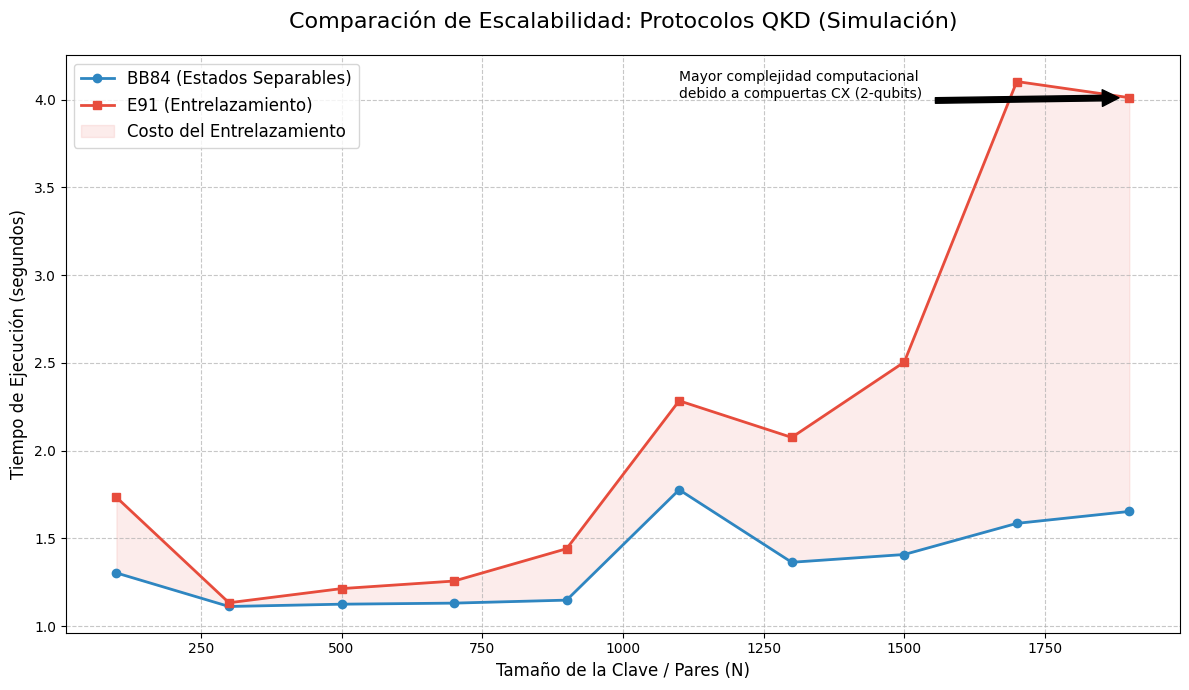

In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# ==============================================================================
# 1. RECONSTRUCCIÓN DE LIBRERÍAS (Lógica Cuántica)
# ==============================================================================

# --- FUNCIONES BB84 (Estados Separables) ---
def prepare_alice_states(n_qubits):
    """Prepara N qubits en estados aleatorios |0>, |1>, |+>, |->."""
    bits = np.random.randint(2, size=n_qubits)
    bases = np.random.randint(2, size=n_qubits)
    qc = QuantumCircuit(n_qubits, n_qubits)

    # Vectorizado (aplicación lógica simplificada para rendimiento)
    for i in range(n_qubits):
        if bits[i] == 1:
            qc.x(i)
        if bases[i] == 1:
            qc.h(i)
    return qc, bits, bases

def measure_bob_states(qc, bob_bases):
    """Aplica las bases de medición de Bob."""
    n = len(bob_bases)
    for i in range(n):
        if bob_bases[i] == 1:
            qc.h(i)
        qc.measure(i, i)
    return qc

# --- FUNCIONES E91 (Estados Entrelazados) ---
def generar_pares_bell(n_pares):
    """Genera N pares de Bell (2N qubits totales)."""
    # Se necesitan 2*N qubits.
    # Qubit 2*i y 2*i+1 forman el par i.
    qc = QuantumCircuit(2 * n_pares, 2 * n_pares)
    for i in range(n_pares):
        q_a = 2 * i      # Qubit de Alice
        q_b = 2 * i + 1  # Qubit de Bob
        qc.h(q_a)
        qc.cx(q_a, q_b)
    return qc

def aplicar_mediciones_e91(qc, bases_a, bases_b):
    """Aplica mediciones para Alice y Bob en sus respectivos qubits."""
    n_pares = len(bases_a)
    for i in range(n_pares):
        q_a = 2 * i
        q_b = 2 * i + 1

        # Base Alice
        if bases_a[i] == 1:
            qc.h(q_a) # Base X
        # Si base es 0 (Z), no se hace nada antes de medir

        # Base Bob
        if bases_b[i] == 1:
            qc.h(q_b)

        qc.measure(q_a, 2*i)     # Medir Alice al bit clásico par
        qc.measure(q_b, 2*i+1)   # Medir Bob al bit clásico impar
    return qc

# --- SIMULACIÓN COMÚN (Backend Stabilizer) ---
# Usamos 'stabilizer' porque es el único capaz de simular miles de qubits
# en Clifford gates (H, CX, X, Z) eficientemente.
SIMULADOR = AerSimulator(method='stabilizer')

def run_simulation(qc):
    # Transpilación mínima necesaria para el backend
    qc = transpile(qc, SIMULADOR)
    result = SIMULADOR.run(qc, shots=1, memory=True).result()
    # Extraemos la memoria (bitstring)
    memory = result.get_memory()[0]
    # Convertimos string a lista de enteros [bit_N, ..., bit_0]
    # Ojo: Qiskit devuelve el string invertido (little-endian).
    bits = np.array([int(x) for x in memory[::-1]])
    return bits

# ==============================================================================
# 2. MOTOR DE BENCHMARKING
# ==============================================================================

def benchmark_protocolo(protocolo, n_items):
    """
    Ejecuta una iteración de medición de tiempo.
    n_items: n_qubits para BB84, n_pares para E91.
    """
    t_start = time.perf_counter()

    if protocolo == 'BB84':
        # 1. Preparación
        qc, a_bits, a_bases = prepare_alice_states(n_items)
        # 2. Medición
        b_bases = np.random.randint(2, size=n_items)
        qc = measure_bob_states(qc, b_bases)
        # 3. Simulación
        res_bits = run_simulation(qc)
        # (El sifting es despreciable en tiempo comparado con simulación, lo omitimos para pureza cuántica)

    elif protocolo == 'E91':
        # 1. Generación Pares
        qc = generar_pares_bell(n_items)
        # 2. Configuración Bases
        bases_a = np.random.randint(2, size=n_items)
        bases_b = np.random.randint(2, size=n_items)
        qc = aplicar_mediciones_e91(qc, bases_a, bases_b)
        # 3. Simulación
        res_bits = run_simulation(qc)

    t_end = time.perf_counter()
    return t_end - t_start

# ==============================================================================
# 3. EJECUCIÓN DEL ESTUDIO COMPARATIVO
# ==============================================================================

print(f"{'='*60}")
print(f"{'COMPARATIVA DE RENDIMIENTO: BB84 vs E91':^60}")
print(f"{'='*60}")
print("Configuración: Qiskit Aer (Method: Stabilizer)")
print("Nota: Para E91, N representa PARES (2 qubits por N).")
print("-" * 60)

# Rango de prueba (Reducido para demo rápida, aumenta el rango si estás en local)
# En tus scripts originales usabas hasta 3000.
valores_N = np.arange(100, 2100, 200)

tiempos_bb84 = []
tiempos_e91 = []

print(f"{'N (Items)':<10} | {'T. BB84 (s)':<15} | {'T. E91 (s)':<15} | {'Factor (E91/BB84)'}")
print("-" * 65)

for N in valores_N:
    # Medir BB84
    t_bb84 = benchmark_protocolo('BB84', N)
    tiempos_bb84.append(t_bb84)

    # Medir E91
    t_e91 = benchmark_protocolo('E91', N)
    tiempos_e91.append(t_e91)

    ratio = t_e91 / t_bb84 if t_bb84 > 0 else 0
    print(f"{N:<10} | {t_bb84:.4f}          | {t_e91:.4f}          | {ratio:.2f}x")

# ==============================================================================
# 4. VISUALIZACIÓN DE RESULTADOS
# ==============================================================================

plt.figure(figsize=(12, 7))

# Curvas de datos
plt.plot(valores_N, tiempos_bb84, 'o-', color='#2E86C1', label='BB84 (Estados Separables)', linewidth=2, markersize=6)
plt.plot(valores_N, tiempos_e91, 's-', color='#E74C3C', label='E91 (Entrelazamiento)', linewidth=2, markersize=6)

# Área de diferencia
plt.fill_between(valores_N, tiempos_bb84, tiempos_e91, color='#E74C3C', alpha=0.1, label='Costo del Entrelazamiento')

# Ajustes estéticos
plt.title("Comparación de Escalabilidad: Protocolos QKD (Simulación)", fontsize=16, pad=20)
plt.xlabel("Tamaño de la Clave / Pares (N)", fontsize=12)
plt.ylabel("Tiempo de Ejecución (segundos)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Anotación de complejidad
plt.annotate('Mayor complejidad computacional\ndebido a compuertas CX (2-qubits)',
             xy=(valores_N[-1], tiempos_e91[-1]),
             xytext=(valores_N[int(len(valores_N)/2)], tiempos_e91[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()